# Extractor tutorial for Pic du Midi Data

The goal of this notebook is to demonstrate the capabilities of the Spectractor pipeline (still under construction). This pipeline is designed to extract a spectrum from an image given the coordinate (in pixels) of the object.

It can be applied to not rotated and pre-rotated reduced images.
Normally all the required information has been put by reduction in the image header.
However it is possible to retrieve this information from logbook.

## Import the pipeline

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import re

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)
#os.chdir(workbookDir)  # If you changed the current working dir, this will take you back to the workbook dir.

workbookDir: /Users/dagoret/MacOSX/GitHub/LSST/Spectractor/notebooks


In [5]:
import sys
sys.path.append(workbookDir)
sys.path.append(os.path.dirname(workbookDir))

In [6]:
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.logbook import LogBook

if __name__ == "__main__":
    from argparse import ArgumentParser

    parser = ArgumentParser()
    parser.add_argument(dest="input", metavar='path', default=["tests/data/reduc_20170605_028.fits"],
                        help="Input fits file name. It can be a list separated by spaces, or it can use * as wildcard.",
                        nargs='*')
    parser.add_argument("-d", "--debug", dest="debug", action="store_true",
                        help="Enter debug mode (more verbose and plots).", default=False)
    parser.add_argument("-v", "--verbose", dest="verbose", action="store_true",
                        help="Enter verbose (print more stuff).", default=False)
    parser.add_argument("-o", "--output_directory", dest="output_directory", default="outputs/",
                        help="Write results in given output directory (default: ./outputs/).")
    parser.add_argument("-l", "--logbook", dest="logbook", default="ctiofulllogbook_jun2017_v5.csv",
                        help="CSV logbook file. (default: ctiofulllogbook_jun2017_v5.csv).")
    parser.add_argument("-c", "--config", dest="config", default="config/ctio.ini",
                        help="INI config file. (default: config.ctio.ini).")
    args = parser.parse_args()


# Configuration

In [7]:
FLAG_ROTATION=False

## Flags

In [8]:
parameters.VERBOSE = True
parameters.DEBUG = False

## Date

In [9]:
#thedate="20190214"
thedate="20190215"

In [10]:
! ls ../*.csv

../allobs_logbook_PicDuMidi_20190215_v4_filter_None.csv
../ctiofulllogbook_jun2017_V2.csv
../ctiofulllogbook_jun2017_v4.csv
../ctiofulllogbook_jun2017_v5.csv
../simple_logbook_PicDuMidi_20190214.csv
../simple_logbook_PicDuMidi_20190214_rot_v2.csv
../simple_logbook_PicDuMidi_20190214_v2.csv
../simple_logbook_PicDuMidi_20190214_v4.csv
../simple_logbook_PicDuMidi_20190214_v4_filter_None_marcsel_july19.csv
../simple_logbook_PicDuMidi_20190215.csv
../simple_logbook_PicDuMidi_20190215_rot_v2.csv
../simple_logbook_PicDuMidi_20190215_v2.csv
../simple_logbook_PicDuMidi_20190215_v4.csv


## Logbook

In [11]:
#if FLAG_ROTATION:
#    logbookfilename="../simple_logbook_PicDuMidi_"+thedate+"_rot_v2.csv"
#else:
#    logbookfilename="../simple_logbook_PicDuMidi_"+thedate+"_v2.csv"

In [12]:
#This above defines the logbbok to be used
#------------------------------------
if FLAG_ROTATION:
    logbookfilename = "../simple_logbook_PicDuMidi_" + thedate + "_rot_v2.csv"
else:
    #logbookfilename = "simple_logbook_PicDuMidi_" + thedate + "_v2.csv"
    #logbookfilename = "simple_logbook_PicDuMidi_" + thedate + "_v4.csv"
    logbookfilename = "../allobs_logbook_PicDuMidi_" + thedate + "_v4_filter_None.csv"
    if thedate == "20190215":
        logbookfilename = "../allobs_logbook_PicDuMidi_" + thedate + "_v4_filter_None.csv"
    else:
        logbookfilename = "../simple_logbook_PicDuMidi_20190214_v4_filter_None_marcsel_july19.csv"

### Read the lobook to test

In [13]:
# good for my logbook
df=pd.read_csv(logbookfilename,sep=",", decimal=".", encoding='latin-1', header='infer')

### For example view the first selected filename for a reduced image 

In [14]:
df

,Unnamed: 0,object,disperser,filt,evnum,flat,airmass,date,exposure,gain,ra,dec,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,file
0,0,HD116405,Holo150PDM19,None,1,FLAT_Filtre_None_bin1x1,1.545961,2019-02-15T22:55:50.730,30.0,4.8,13.379287,44.7106,133.208557,220.877829,50.0,50.0,No,T1M_20190215_225550_730_HD116405_Filtre_None_b...
1,1,HD116405,Holo150PDM19,None,2,FLAT_Filtre_None_bin1x1,1.542936,2019-02-15T22:56:26.007,30.0,4.8,13.379287,44.7106,133.400674,217.614830,50.0,50.0,No,T1M_20190215_225626_007_HD116405_Filtre_None_b...
2,2,HD116405,Holo150PDM19,None,3,FLAT_Filtre_None_bin1x1,1.539925,2019-02-15T22:57:01.284,30.0,4.8,13.379287,44.7106,133.268162,217.958401,50.0,50.0,No,T1M_20190215_225701_284_HD116405_Filtre_None_b...
3,3,HD116405,Holo150PDM19,None,4,FLAT_Filtre_None_bin1x1,1.536929,2019-02-15T22:57:36.562,30.0,4.8,13.379287,44.7106,183.596980,174.986783,50.0,50.0,No,T1M_20190215_225736_562_HD116405_Filtre_None_b...
4,4,HD116405,Holo150PDM19,None,5,FLAT_Filtre_None_bin1x1,1.533947,2019-02-15T22:58:11.838,30.0,4.8,13.379287,44.7106,180.257505,174.551341,50.0,50.0,No,T1M_20190215_225811_838_HD116405_Filtre_None_b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,533,HD116405,Holo150PDM19,None,455,FLAT_Filtre_None_bin1x1,1.044350,2019-02-16T05:12:03.565,30.0,4.8,13.379287,44.7106,561.098101,248.445783,50.0,50.0,No,T1M_20190216_051203_565_HD116405_Filtre_None_b...
534,534,HD116405,Holo150PDM19,None,456,FLAT_Filtre_None_bin1x1,1.044928,2019-02-16T05:12:38.844,30.0,4.8,13.379287,44.7106,573.445005,244.149212,50.0,50.0,No,T1M_20190216_051238_844_HD116405_Filtre_None_b...
535,535,HD116405,Holo150PDM19,None,457,FLAT_Filtre_None_bin1x1,1.045509,2019-02-16T05:13:14.122,30.0,4.8,13.379287,44.7106,583.718836,241.987003,50.0,50.0,No,T1M_20190216_051314_122_HD116405_Filtre_None_b...
536,536,HD116405,Holo150PDM19,None,458,FLAT_Filtre_None_bin1x1,1.046095,2019-02-16T05:13:49.401,30.0,4.8,13.379287,44.7106,206.135080,225.930582,50.0,50.0,No,T1M_20190216_051349_401_HD116405_Filtre_None_b...


## Input filename

In [15]:
if thedate=="20190215":
    if FLAG_ROTATION:
        INPUTDIR="/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v5"
    else:
        INPUTDIR="/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4"
else:
    if FLAG_ROTATION:
        INPUTDIR="/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190214_v5"
    else:
        INPUTDIR="/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190214_v4"

In [16]:
if thedate=="20190215":
    if FLAG_ROTATION:
        file_name="T1M_20190216_013144_582_HD116405_Filtre_None_bin1x1.111_red_rot.fit"
    else:
        file_name="T1M_20190216_013144_582_HD116405_Filtre_None_bin1x1.111_red.fit"

else:
    if FLAG_ROTATION:
        file_name="T1M_20190214_234122_495_HD116405-Ronchi_Filtre_None_bin1x1.1_red_rot.fit"
    else:
        file_name="T1M_20190214_234122_495_HD116405-Ronchi_Filtre_None_bin1x1.1_red.fit"

## Find the file index in logbook of the file selected above

In [17]:
file_index=np.where(df.file.values==file_name)[0][0]

In [18]:
df.iloc[file_index]

Unnamed: 0                                                   214
object                                                  HD116405
disperser                                           Holo150PDM19
filt                                                        None
evnum                                                        111
flat                                     FLAT_Filtre_None_bin1x1
airmass                                                  1.08685
date                                     2019-02-16T01:31:44.582
exposure                                                      30
gain                                                         4.8
ra                                                       13.3793
dec                                                      44.7106
Obj-posXpix                                              225.923
Obj-posYpix                                              228.914
Dx                                                            50
Dy                       

## Output directory

In [19]:
output_directory="output/"+thedate

## Config

In [20]:
if FLAG_ROTATION:
    config="../config/picdumidirot.ini"
else:
    config="../config/picdumidi.ini"

# Run Logbook

In [21]:
df=pd.read_csv(logbookfilename)

In [22]:
df

,Unnamed: 0,object,disperser,filt,evnum,flat,airmass,date,exposure,gain,ra,dec,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,file
0,0,HD116405,Holo150PDM19,None,1,FLAT_Filtre_None_bin1x1,1.545961,2019-02-15T22:55:50.730,30.0,4.8,13.379287,44.7106,133.208557,220.877829,50.0,50.0,No,T1M_20190215_225550_730_HD116405_Filtre_None_b...
1,1,HD116405,Holo150PDM19,None,2,FLAT_Filtre_None_bin1x1,1.542936,2019-02-15T22:56:26.007,30.0,4.8,13.379287,44.7106,133.400674,217.614830,50.0,50.0,No,T1M_20190215_225626_007_HD116405_Filtre_None_b...
2,2,HD116405,Holo150PDM19,None,3,FLAT_Filtre_None_bin1x1,1.539925,2019-02-15T22:57:01.284,30.0,4.8,13.379287,44.7106,133.268162,217.958401,50.0,50.0,No,T1M_20190215_225701_284_HD116405_Filtre_None_b...
3,3,HD116405,Holo150PDM19,None,4,FLAT_Filtre_None_bin1x1,1.536929,2019-02-15T22:57:36.562,30.0,4.8,13.379287,44.7106,183.596980,174.986783,50.0,50.0,No,T1M_20190215_225736_562_HD116405_Filtre_None_b...
4,4,HD116405,Holo150PDM19,None,5,FLAT_Filtre_None_bin1x1,1.533947,2019-02-15T22:58:11.838,30.0,4.8,13.379287,44.7106,180.257505,174.551341,50.0,50.0,No,T1M_20190215_225811_838_HD116405_Filtre_None_b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,533,HD116405,Holo150PDM19,None,455,FLAT_Filtre_None_bin1x1,1.044350,2019-02-16T05:12:03.565,30.0,4.8,13.379287,44.7106,561.098101,248.445783,50.0,50.0,No,T1M_20190216_051203_565_HD116405_Filtre_None_b...
534,534,HD116405,Holo150PDM19,None,456,FLAT_Filtre_None_bin1x1,1.044928,2019-02-16T05:12:38.844,30.0,4.8,13.379287,44.7106,573.445005,244.149212,50.0,50.0,No,T1M_20190216_051238_844_HD116405_Filtre_None_b...
535,535,HD116405,Holo150PDM19,None,457,FLAT_Filtre_None_bin1x1,1.045509,2019-02-16T05:13:14.122,30.0,4.8,13.379287,44.7106,583.718836,241.987003,50.0,50.0,No,T1M_20190216_051314_122_HD116405_Filtre_None_b...
536,536,HD116405,Holo150PDM19,None,458,FLAT_Filtre_None_bin1x1,1.046095,2019-02-16T05:13:49.401,30.0,4.8,13.379287,44.7106,206.135080,225.930582,50.0,50.0,No,T1M_20190216_051349_401_HD116405_Filtre_None_b...


In [23]:
df.iloc[file_index]["file"]

'T1M_20190216_013144_582_HD116405_Filtre_None_bin1x1.111_red.fit'

In [24]:
logbook = LogBook(logbookfilename)

In [25]:
tag_file=file_name

In [26]:
disperser_label, target, xpos, ypos = logbook.search_for_image(tag_file)

In [27]:
disperser_label

'Holo150PDM19'

In [28]:
target

'HD116405'

In [29]:
xpos,ypos

(225, 228)

In [30]:
fullfilename=os.path.join(INPUTDIR,file_name)

In [31]:
fullfilename

'/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4/T1M_20190216_013144_582_HD116405_Filtre_None_bin1x1.111_red.fit'

# Run Spectractor

2019-10-17 16:32:01  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2019-10-17 16:32:01  Image      load_PDM_image       INFO   
	Loading Pic du Midi image /Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4/T1M_20190216_013144_582_HD116405_Filtre_None_bin1x1.111_red.fit...
2019-10-17 16:32:02  Image      load_PDM_image       INFO   
	Image loaded
2019-10-17 16:32:02  Image      load_LogBook         INFO   
	Load Logbook  ../allobs_logbook_PicDuMidi_20190215_v4_filter_None.csv for /Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4/T1M_20190216_013144_582_HD116405_Filtre_None_bin1x1.111_red.fit...
2019-10-17 16:32:02  Image      load_LogBook         INFO   
	Load Logbook  : date identified  SEL_DATE=20190215 for imagefile=/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4/T1M_20190216_013144_582_HD116405_Filtre_None_bin1x1.111_red.fit, FLAG_ROTATION=False...
2019-10-17 16:32:02  Image      load_LogBook         WARNING 
	Load Logbook  :  tag_date 

Section: paths
x holo_dir: extractor/dispersers/	 => parameters.HOLO_DIR: /Users/dagoret/MacOSX/GitHub/LSST/Spectractor/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/CTIOThroughput/	 => parameters.THROUGHPUT_DIR: /Users/dagoret/MacOSX/GitHub/LSST/Spectractor/spectractor/simulation/CTIOThroughput/	 <class 'str'>
Section: instrument
x obs_name: PICDUMIDI	 => parameters.OBS_NAME: PICDUMIDI	 <class 'str'>
x obs_altitude: 2.8905	 => parameters.OBS_ALTITUDE: 2.8905	 <class 'float'>
x obs_longitude: 0 08 34.00	 => parameters.OBS_LONGITUDE: 0 08 34.00	 <class 'str'>
x obs_latitude: 42 56 11.00	 => parameters.OBS_LATITUDE: 42 56 11.00	 <class 'str'>
x obs_diameter: 1.0	 => parameters.OBS_DIAMETER: 1.0 m	 <class 'astropy.units.quantity.Quantity'>
x obs_epoch: J2000.0	 => parameters.OBS_EPOCH: J2000.0	 <class 'str'>
x obs_transmission_systematics: 0.005	 => parameters.OBS_TRANSMISSION_SYSTEMATICS: 0.005	 <class 'float'>
x obs_object_type: STAR	 => parameters.OBS_OB

2019-10-17 16:32:02  Image      load_PDM_image       INFO   
	Image loaded
2019-10-17 16:32:02  Image      load_PDM_image       WARNING 
	load_PDM_image :: paralactic angle = -15.461196019701413  ...
2019-10-17 16:32:02  Image      load_image           INFO   
	Loading disperser Holo150PDM19...


Load disperser Holo150PDM19:
	from /Users/dagoret/MacOSX/GitHub/LSST/Spectractor/spectractor/extractor/dispersers/Holo150PDM19
Grating characteristics:
	N = 150.00 +/- 1.14 grooves/mm
	Average tilt of 45.0 degrees


2019-10-17 16:32:02  Star       load                 INFO   
	Simbad:  MAIN_ID        RA           DEC      RA_PREC ... SP_TYPE SP_QUAL SP_BIBCODE
             "h:m:s"       "d:m:s"            ...                           
--------- ------------- ------------- ------- ... ------- ------- ----------
HD 116405 13 22 45.1237 +44 42 53.911      14 ...     A0V       C           


Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd116405_stis_003.fits
Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd116405_stis_002.fits
Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd116405_stis_004.fits
Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd116405_stis_001.fits


2019-10-17 16:32:03  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the original image...
2019-10-17 16:32:13  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 2
Parameters:
           c0_0             c1_0       ...         c1_1        
    ----------------- ---------------- ... --------------------
    6.997345597322744 0.39940353789606 ... 0.003193907336947999
2019-10-17 16:32:16  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 2
Parameters:
           c0_0              c1_0       ...        c0_2                c1_1       
    ------------------ ---------------- ... ------------------ -------------------
    11.978153810592964 9.56620071111994 ... -0.288669213577221 0.16342798121991872
2019-10-17 16:32:16  Image      find_target          INFO   
	X,Y target position in pixe

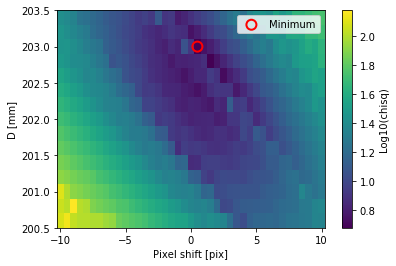

2019-10-17 16:41:26  Spectrum   calibrate_spectrum_with_lines INFO   
	Order0 total shift: 0.50pix
	D = 203.00 mm (default: DISTANCE2CCD = 202.00 +/- 0.20 mm, 5.0 sigma shift)
2019-10-17 16:41:26  spectractor.extractor.extractor Spectractor          INFO   
	Save Spectrum in {output_filename}...
2019-10-17 16:41:26  spectractor.extractor.extractor Spectractor          INFO   
	Save Spectrogram in {output_filename_spectrogram}...
2019-10-17 16:41:26  Spectrum   save_spectrum        INFO   
	Spectrum saved in output/20190215/T1M_20190216_013144_582_HD116405_Filtre_None_bin1x1.111_red_spectrum.fits
2019-10-17 16:41:26  Spectrum   save_spectrogram     INFO   
	Spectrogram saved in output/20190215/T1M_20190216_013144_582_HD116405_Filtre_None_bin1x1.111_red_spectrogram.fits


   Line   Tabulated  Detected    Shift    ...   Amplitude       SNR      Chisq  
              nm        nm         nm     ...                           reduced 
--------- --------- --------- ----------- ... -------------- --------- ---------
     $Fe$   382.044 384.54224   2.4982412 ... -2.5901783e-12  26.10483 2.2280889
$Ca_{II}$   393.366 389.24203   -4.123972 ... -2.0633473e-12 20.795223 2.2280889
$Ca_{II}$   396.847 396.68875 -0.15826206 ... -4.1728066e-12  42.05518 2.2280889
$H\delta$     410.2   409.734 -0.46597916 ...  -4.754523e-12 47.917946 2.2280889
     $Fe$    430.79  430.1162  -0.6737782 ... -5.6806374e-12 57.251686 2.2280889
$H\gamma$     434.0 433.41803 -0.58197373 ... -6.9223976e-12  69.76663 2.2280889
     $Fe$   438.355  439.5652   1.2101879 ... -6.1178263e-12 61.657845 2.2280889
 $H\beta$     486.3 484.99954  -1.3004645 ...  -7.847071e-12 74.719154 2.9950652
$H\alpha$     656.3  654.1034  -2.1966057 ... -2.2341885e-12 34.138878  1.846221
 $O_2(B)$   686.719  686.243

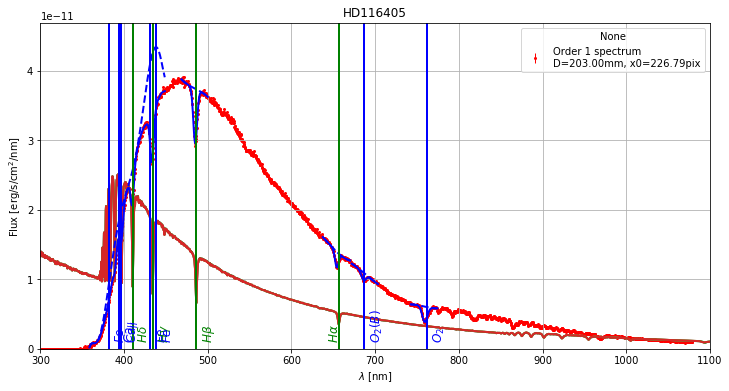

In [33]:
Spectractor(fullfilename,output_directory, [xpos, ypos], target, disperser_label, config,logbook=logbookfilename)